In [30]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt 
import cartopy.crs as ccrs

In [32]:
from src.multi_model_large_ensemble import MultiModelLargeEnsemble

In [33]:
import dask
def convert_longitude_360to180(ds):
    """Convert ds from 0 to 360 longitude to -180 to 180 coordinate

    Parameters
    ----------
    ds: xr.Dataset
        CMIP model dataset

    Returns
    -------
    ds: xr.Dataset
        Same CMIP dataset with converted longitude
    """
    ds = ds.assign_coords({'lon': ds.lon.where(ds.lon <= 180, ds.lon - 360)})
    # To silence large chunk warning
    with dask.config.set(**{'array.slicing.split_large_chunks': True}):
        ds = ds.sortby(ds.lon)
    return ds

In [34]:
scenarios = ['ssp126', 'ssp245', 'ssp370', 'ssp585']

In [35]:
variable = 'pr'
mmle_scenarios_x=[]
mmle_scenarios_results=[]
for scenario in  ['ssp126', 'ssp245', 'ssp370', 'ssp585']:
    mmle_loaded = MultiModelLargeEnsemble('cmip6', variable, 'day', 
                               lat=slice(None, None), lon=slice(None, None), scenario=scenario,
                               bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')
    mmle_loaded.compute_x(x_type='quantile_return', load=True, name=f'cmip6_{scenario}_{variable}_default_quantile_return_10yr')
    mmle_loaded.compute_FIT()
    mmle_scenarios_x.append(mmle_loaded.x)
    mmle_scenarios_results.append(mmle_loaded.results)

gcs://climateai_data_repository/tmp/global_cmip_2.5deg/cmip6/historical/day/pr.zarr gcs://climateai_data_repository/tmp/global_cmip_2.5deg/cmip6/ssp126/day/pr.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/cmip6_ssp126_pr_default_quantile_return_10yr/MPI-ESM1-2-LR.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/cmip6_ssp126_pr_default_quantile_return_10yr/MIROC6.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/cmip6_ssp126_pr_default_quantile_return_10yr/EC-Earth3.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/cmip6_ssp126_pr_default_quantile_return_10yr/MPI-ESM1-2-HR.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/cmip6_ssp126_pr_default_quantile_return_10yr/IPSL-CM6A-LR.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/cmip6_ssp126_pr_default_quantile_return_10yr/EC-Earth3-Veg-LR.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/cmip6_ssp126_

In [36]:
mmle_loaded.results = xr.concat(mmle_scenarios_results, scenarios).rename({'concat_dim':'scenario'})
mmle_loaded.x = xr.concat(mmle_scenarios_x, scenarios).rename({'concat_dim':'scenario'})

In [37]:
mmle_loaded.results.load()

/opt/conda/envs/carla/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.Dataset>
Dimensions:    (model: 14, lat: 71, lon: 144, time: 130, scenario: 4)
Coordinates:
  * model      (model) <U30 'MPI-ESM1-2-LR' 'MIROC6' ... 'GFDL-ESM4' 'CMCC-ESM2'
  * lat        (lat) float64 -87.5 -85.0 -82.5 -80.0 ... 80.0 82.5 85.0 87.5
  * lon        (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time       (time) datetime64[ns] 1970-01-01 1971-01-01 ... 2099-01-01
    member_id  <U8 'r1i1p1f1'
    q_values   (model, lat, lon) float64 2.715e-05 2.656e-05 ... 0.0001683
    quantile   float64 0.9997
  * scenario   (scenario) <U6 'ssp126' 'ssp245' 'ssp370' 'ssp585'
Data variables:
    FIT        (scenario, time, model, lat, lon) float64 2.215 1.699 ... 8.938
    M_FIT      (scenario, time, lat, lon) float64 2.957 2.377 ... 28.48 39.78
    I_FIT      (scenario, model, lat, lon) float64 1.081 1.207 ... 0.9253 1.191
    Ibar_FIT   (scenario, lat, lon) float64 1.482 1.27 1.265 ... 1.812 1.616
    T_FIT      (scenario, time, lat, lon) float64 nan nan nan ... nan nan nan

In [38]:
mmle_loaded.x.load()

<xarray.DataArray 'pr' (scenario: 4, model: 14, member_id: 1, time: 130, lat: 71, lon: 144)>
array([[[[[[nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan],
           ...,
           [nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan]],

          [[nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan],
           ...,
           [nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan]],

          [[nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan],
           ...,
...
           ...,
           [nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan]],

          [[nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan],
           ...,
           [nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan]],

          [[nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan],
           ...,
           [nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan]]]]]])
Coordinates:
  * lat        (lat) float64 -87.5 -85.0 -82.5 -80.0 ... 80.0 82.5 85.0 87.5
  * lon        (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * member_id  (member_id) <U8 'r1i1p1f1'
  * model      (model) <U30 'MPI-ESM1-2-LR' 'MIROC6' ... 'GFDL-ESM4' 'CMCC-ESM2'
    q_values   (model, lat, lon) float64 2.715e-05 2.656e-05 ... 0.0001683
    quantile   float64 0.9997
  * time       (time) datetime64[ns] 1970-01-01 1971-01-01 ... 2099-01-01
  * scenario   (scenario) <U6 'ssp126' 'ssp245' 'ssp370' 'ssp585'

In [39]:
mmle_loaded.results['S_FIT'] = mmle_loaded.x.mean('model').var('scenario').isel(member_id=0)

In [40]:
mmle_loaded.results['T_FIT'] = mmle_loaded.results['M_FIT'].mean('scenario')+ mmle_loaded.results['Ibar_FIT'].mean('scenario') + mmle_loaded.results['S_FIT']

In [51]:
results = convert_longitude_360to180(mmle_loaded.results)

In [52]:
results['Ibar_FIT_FRAC'] = results['Ibar_FIT'].mean('scenario')/results['T_FIT']
results['M_FIT_FRAC'] = results['M_FIT'].mean('scenario')/results['T_FIT']
results['S_FIT_FRAC'] = results['S_FIT']/results['T_FIT']

In [53]:
time_1 = slice('2005', '2014')
time_2 = slice('2035', '2044')
time_3 = slice('2065', '2075')

data = [
results['Ibar_FIT_FRAC'].sel(time=time_1).mean('time'),
results['M_FIT_FRAC'].sel(time=time_1).mean('time'),
results['S_FIT_FRAC'].sel(time=time_1).mean('time'),

results['Ibar_FIT_FRAC'].sel(time=time_2).mean('time'),
results['M_FIT_FRAC'].sel(time=time_2).mean('time'),
results['S_FIT_FRAC'].sel(time=time_2).mean('time'),

results['Ibar_FIT_FRAC'].sel(time=time_3).mean('time'),
results['M_FIT_FRAC'].sel(time=time_3).mean('time'),
results['S_FIT_FRAC'].sel(time=time_3).mean('time'),

]

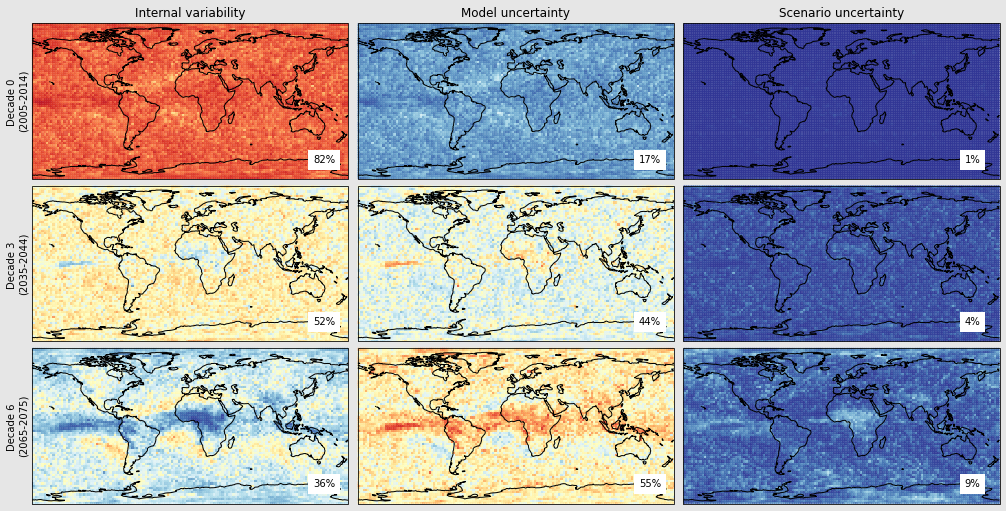

In [44]:
# fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(25,10), subplot_kw=dict(projection=ccrs.PlateCarree()))  
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(14,7), subplot_kw=dict(projection=ccrs.PlateCarree()))  # To ensure same fontsize, make sure ALL figures have same width!

# orig_map=plt.cm.RdYlBu
reversed_map = plt.cm.RdYlBu_r   # Hack for getting reverse colormaps in matplotlib.

regions = ['USeast','USwest','iceland','europe','australia','tropics']
proj = ccrs.PlateCarree()
titles = [
    "Internal variability",
    "Model uncertainty",
    "Scenario uncertainty",
    None,
    None,
    None,
    None,
    None,
    None,
]
y_labels = [
    'Decade 0 \n(2005-2014)',
    None,
    None,
    'Decade 3 \n(2035-2044)',
    None,
    None,
    'Decade 6 \n(2065-2075)',
    None,
    None,
]
for ax, data_i, title, y_label in zip(axes.ravel(), data, titles, y_labels):
    percentage = int(np.round((data_i.mean(('lat', 'lon'))*100).values))
#     ax.coastlines(linewidth=2, color='gray')
    data_i.plot(ax=ax, cmap=reversed_map, 
    vmin = 0, vmax = 1,
    add_colorbar=False,
#     add_colorbar=True, cbar_kwargs={'orientation': 'horizontal', 'shrink': 0.7, 'pad': 0.01},
    alpha=0.9   # This makes it a little less jarring
    )
    ax.set_title(title)
    ax.text(140, -70, f'{percentage}%',
        bbox={'facecolor': 'white', 
            'alpha': 1, 'pad': 5, 
            'edgecolor' : 'none'})
    if y_label:
        ax.text(-0.01, 0.5, y_label, va='bottom', ha='center',
                rotation='vertical', rotation_mode='anchor',
                transform=ax.transAxes)
    ax.coastlines(linewidth=1, color='k')

# plt.subplots_adjust(left=0.05, bottom=0.02, wspace=0, hspace=0.03)
plt.subplots_adjust(left=0.03, right=0.99, bottom=0.01, top=0.97, wspace=0.03, hspace=0.02)  # all parameters MUST be specified for reproducibility!
# plt.show()   # Not really necessary
#fig.patch.set_facecolor('0.9')   # Hack to get grayscale. To see actual figure size.
# Add colorbar in post-production, plot separately, then cut and paste in PowerPoint, etc.

In [45]:
fig.savefig(f'./plots/{variable}_cmip_global_fractions.png', dpi=200)

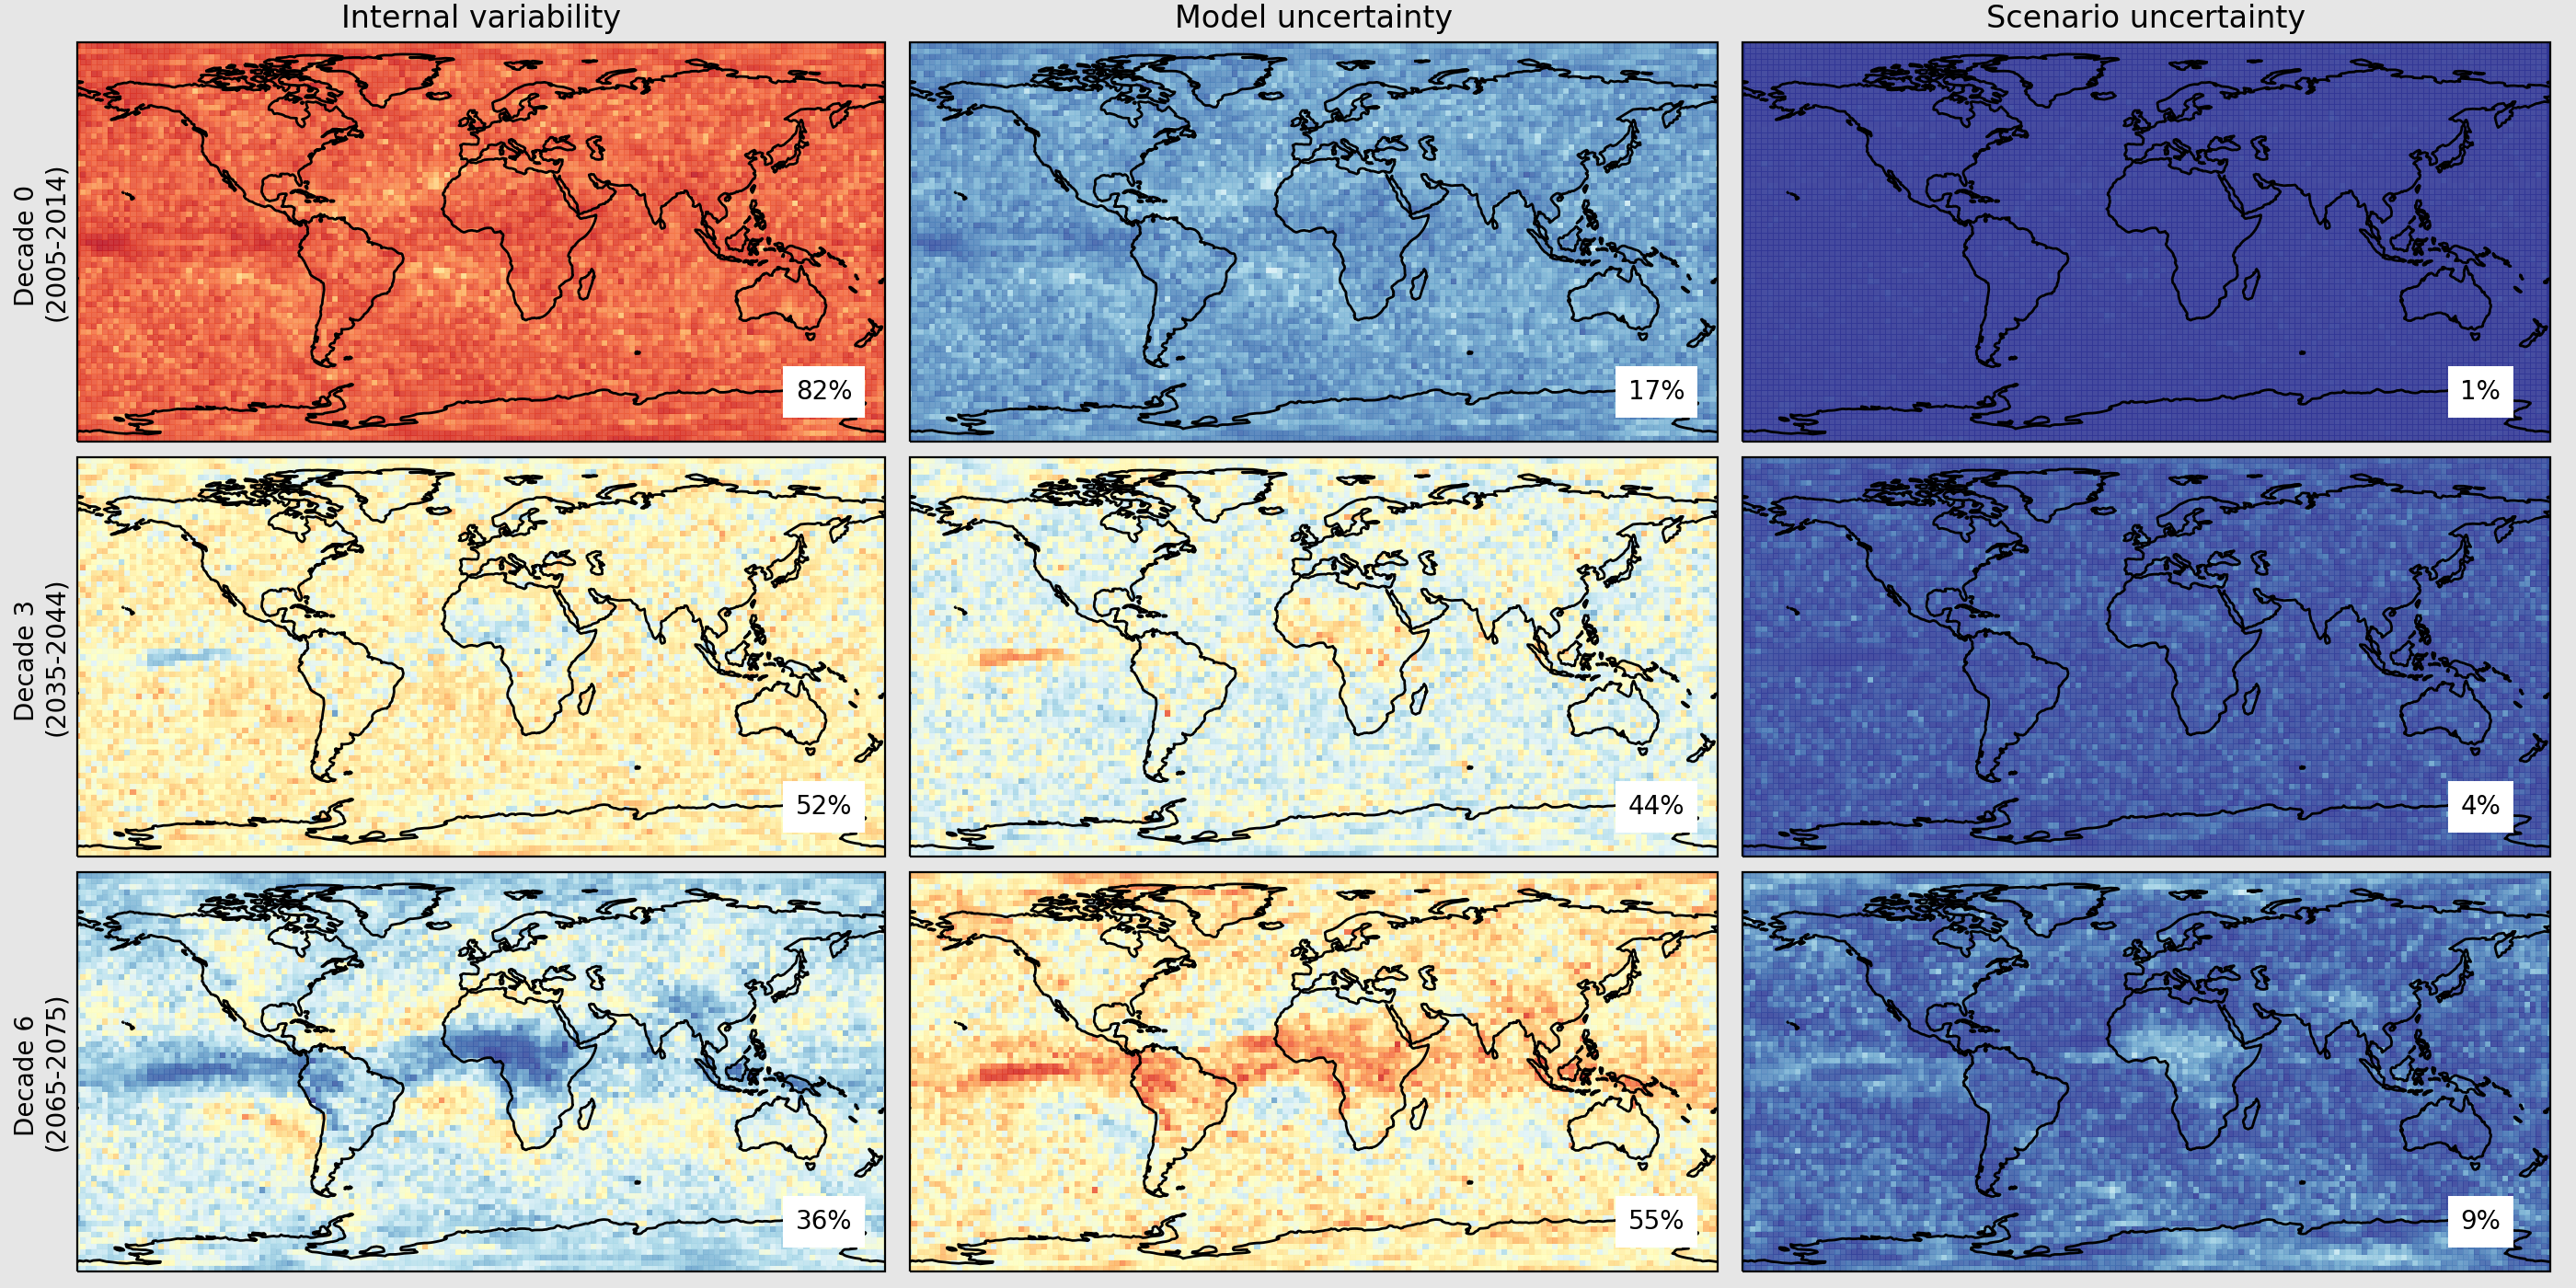

In [46]:
from IPython.display import Image
Image(filename=f'./plots/{variable}_cmip_global_fractions.png')   # Don't believe what Jupyter shows you!

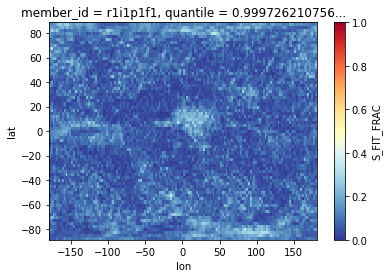

In [47]:
    data_i.plot(cmap=reversed_map, 
    vmin = 0, vmax = 1,
    add_colorbar=True,
    )

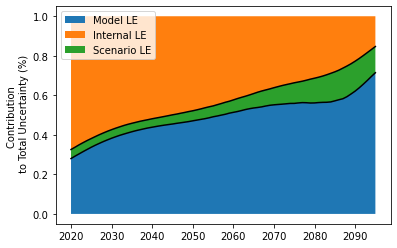

In [54]:
# plot total uncertainty (direct and indirect) 

x=results.sel(time=slice('2020', None)).time.values
y1=results['M_FIT_FRAC'].mean(('lat', 'lon')).sel(time=slice('2020', None))

y2=y1 + results['S_FIT_FRAC'].mean(('lat', 'lon')).sel(time=slice('2020', None))
plt.fill_between(x,0,y1,label='Model LE')
plt.plot(x,y1,color='k')
plt.plot(x,y2,color='k')

plt.fill_between(x,y2,1,label='Internal LE')
plt.fill_between(x,y1,y2,label='Scenario LE')

plt.ylabel('Contribution \n to Total Uncertainty (%)')
plt.legend()
